# Fermion back-end workflow demonstration

In cold atoms, we do not necessarily work with qubits. In cold atoms, we can also work with fermionic atoms the hop through optical lattice systems. The most common examples are Li6 or K40 atoms moving through the optical lattice system. This approach is now used in the [FermiQP](https://www.mpq.mpg.de/6547261/fermiqp) project to implement a quantum processor.

The fermionic tweezer backend, implements four optical lattice sites with possibility of spin up and down. In the following tutorial, we will present you have to implement computing sequences on this simulator device through our standard API. The communication with the backend happens through the four url

1. '.../api/v2/fermions/get_config/' 
2. '.../api/v2/fermions/post_job/'
3. '.../api/v2/fermions/get_job_status/'
4. '.../api/v2/fermions/get_job_result/'

An interactive documentation can be also found directly online under the [docs](https://qlued.alqor.io/api/v2/docs).


You can use this tutorial in two ways. For testing of local deployments of `qlued` or the [hosted version](https://qlued.alqor.io) provided by Alqor.

## Optional: Preparation for local deployment

Some first things that you have to do:

- Apply any migrations to your local server `python manage.py migrate`
- Start the server in a tab as `python manage.py runserver`
- You created an account and saved this in the local `credentials.py` file

## Get the configuration

In a first step, we will try to see what are the available backends and what are the capabilities. This can be done through the json API endpoint `get_config` for the `fermions` backend.

In [1]:
import requests
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

This imports the `credentials_v2.py` file you received from us.

In [2]:
from credentials_v2 import username, token

In [3]:
# for local deployment uncomment the following line
# host_url = 'http://localhost:8000/'

# for work with the cloud version uncomment the following line
host_url = "https://qlued.alqor.io/"
url_prefix = host_url + "api/v2/fermions/"

In [4]:
url = url_prefix + "get_config"
pprint(url)
r = requests.get(url, params={"username": username, "token": token})
r_dict = json.loads(r.text)
pprint(r_dict)

'https://qlued.alqor.io/api/v2_beta/fermions/get_config'
{'backend_name': 'alqor_fermionic_tweezer_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['fhop', 'fint', 'fphase'],
 'cold_atom_type': 'fermion',
 'conditional': False,
 'coupling_map': 'linear',
 'description': 'simulator of a fermionic tweezer hardware. The even wires '
                'denote the occupations of the spin-up fermions and the odd '
                'wires denote the spin-down fermions',
 'display_name': 'fermions',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0, 1, 2, 3],
                             [2, 3, 4, 5],
                             [4, 5, 6, 7],
                             [0, 1, 2, 3, 4, 5, 6, 7]],
            'description': 'hopping of atoms to neighboring tweezers',
            'name': 'fhop',
            'parameters': ['j_i'],
            'qasm_def': '{}'},
           {'coupling_map': [[0, 1, 2, 3, 4, 5, 6, 7]],
            'description': 'on-site interaction of atoms

The above json gives us all the necessary information. The system four optical lattice sites, which are represented on eight wires. Alternating wires then represent the alternating spin occupation. For those wires we have implemente the following gates.

 We have implemented:
 
 - `load` which adds a Fermion to the wire.
 - `fhop` which lets Fermions hop.
 - `fint` which describes interactions between fermions.
 - `fphase` which is the chemical potential on the gate.
 - `measure` which reads out the occupation.

## Load gate

In a first step, we have to have to load fermions into the tweezer. Let us start out with that in the following `json`:

- We load atoms into the wire 0, 2 and 7.
- We read out the occupation of wires 0, 2,6 ,7
- We repeat the experiment for 4 shots.

In [5]:
job_payload = {
    "experiment_0": {
        "instructions": [
            ("load", [7], []),
            ("load", [2], []),
            ("load", [0], []),
            ("measure", [0], []),
            ("measure", [2], []),
            ("measure", [6], []),
            ("measure", [7], []),
        ],
        "num_wires": 8,
        "shots": 4,
        "wire_order": "interleaved",
    },
}

Now, that we set up the instruction, we can submit it via the `post_job` endpoint.

In [6]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/fermions/post_job'
{'job_id': '20230401_090204-fermions-fred-d5e10', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


The simulator has now put the job into the queue and we will have to wait until the calculation is finished. To see its test the job status through `get_job_status`.

In [7]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

print(status_response.text)

{"job_id": "20230401_090204-fermions-fred-d5e10", "status": "DONE", "detail": "None; Passed json sanity check; Compilation done. Shots sent to solver.", "error_message": "None"}


As we can see the job is finished, so let us see the results the `get_job_result` endpoint.

In [8]:
url = url_prefix + "get_job_result"

result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

pprint(result_response.json())

{'backend_name': 'alqor_fermionic_tweezer_simulator',
 'backend_version': '0.0.2',
 'experiments': [{'experiment_0': {'instructions': [['load', [7], []],
                                                    ['load', [2], []],
                                                    ['load', [0], []],
                                                    ['measure', [0], []],
                                                    ['measure', [2], []],
                                                    ['measure', [6], []],
                                                    ['measure', [7], []]],
                                   'num_wires': 8,
                                   'shots': 4,
                                   'wire_order': 'interleaved'}}],
 'header': {},
 'job_id': '20230401_090204-fermions-fred-d5e10',
 'qobj_id': None,
 'results': [{'data': {'memory': ['1 1 0 1', '1 1 0 1', '1 1 0 1', '1 1 0 1']},
              'header': {'extra metadata': 'text', 'name': 'experiment_0'},
   

## Hopping

Next we can implement a hopping sequence, where the atoms move from site to site as described in the json below.

In [9]:
n_phases = 11  # number of phases we would like to investigate
phases = np.linspace(0, np.pi, n_phases)  # array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = "experiment_" + str(ii)
    dummy_exp = {
        "instructions": [
            ("load", [0], []),
            ("load", [1], []),
            ("fhop", [0, 1, 2, 3], [phases[ii]]),
            ("measure", [0], []),
            ("measure", [1], []),
            ("measure", [2], []),
            ("measure", [3], []),
        ],
        "num_wires": 8,
        "shots": 9,
        "wire_order": "interleaved",
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
                                   ('measure', [3], [])],
                  'num_wires': 8,
                  'shots': 9,
                  'wire_order': 'interleaved'},
 'experiment_1': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('fhop', [0, 1, 2, 3], [0.3141592653589793]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
                                   ('measure', [3], [])],
                  'num_wires': 8,
                  'shots': 9,
   

In [10]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/fermions/post_job'
{'job_id': '20230401_090252-fermions-fred-3771f', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [11]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

pprint(status_response.json())

{'detail': 'Got your json.',
 'error_message': 'None',
 'job_id': '20230401_090252-fermions-fred-3771f',
 'status': 'INITIALIZING'}


In [12]:
url = url_prefix + "get_job_result"

result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

results_dict = result_response.json()

Once, we obtained the results, we can format them for a nice print out and plot up the time evolution of the hopping atoms.

In [13]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res["data"]["memory"])
    shots = [shot.split(" ") for shot in shots]
    # print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)

measurements = np.array(measurements)

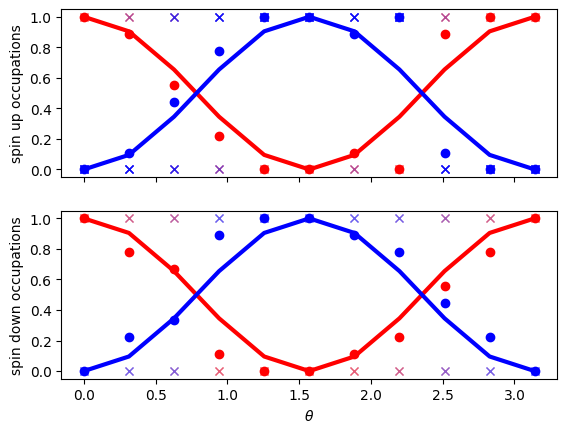

In [14]:
n0s = measurements[:, :, 0]
n1s = measurements[:, :, 1]
n2s = measurements[:, :, 2]
n3s = measurements[:, :, 3]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(phases, n0s, "rx", alpha=0.1)
ax1.plot(phases, n0s.mean(axis=1), "ro")
# ax1.plot(phases, n0s, 'ro', alpha = 0.3)
ax1.plot(phases, (1 + np.cos(2 * phases)) / 2, "r-", lw=3)
ax1.plot(phases, n2s, "bx", alpha=0.3)
ax1.plot(phases, n2s.mean(axis=1), "bo")
ax1.plot(phases, 1 - (1 + np.cos(2 * phases)) / 2, "b-", lw=3)

ax1.set_ylabel(r"spin up occupations")

ax2.plot(phases, n1s, "rx", alpha=0.1)
ax2.plot(phases, n1s.mean(axis=1), "ro")
ax2.plot(phases, (1 + np.cos(2 * phases)) / 2, "r-", lw=3)
ax2.plot(phases, n3s, "bx", alpha=0.1)
ax2.plot(phases, n3s.mean(axis=1), "bo")
ax2.plot(phases, 1 - (1 + np.cos(2 * phases)) / 2, "b-", lw=3)

ax2.set_ylabel("spin down occupations")

ax2.set_xlabel("$\\theta$");

## Interaction a la Selim

In this section we reproduce the results from the experiments that were performed in Heidelberg.

In [23]:
n_phases = 11  # number of phases we would like to investigate
phases = np.linspace(0, np.pi, n_phases)  # array of phases
Ntrott = 5
job_payload = {}

for ii in range(n_phases):
    exp_str = "experiment_" + str(ii)
    dummy_exp = {
        "instructions": [
            ("load", [0], []),
            ("load", [1], []),
            ("fhop", [0, 1, 2, 3], [phases[ii] / Ntrott]),
            ("fint", [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii] / Ntrott]),
            ("fhop", [0, 1, 2, 3], [phases[ii] / Ntrott]),
            ("fint", [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii] / Ntrott]),
            ("fhop", [0, 1, 2, 3], [phases[ii] / Ntrott]),
            ("fint", [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii] / Ntrott]),
            ("fhop", [0, 1, 2, 3], [phases[ii] / Ntrott]),
            ("fint", [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii] / Ntrott]),
            ("fhop", [0, 1, 2, 3], [phases[ii] / Ntrott]),
            ("fint", [0, 1, 2, 3, 4, 5, 6, 7], [phases[ii] / Ntrott]),
            ("measure", [0], []),
            ("measure", [1], []),
            ("measure", [2], []),
            ("measure", [3], []),
        ],
        "num_wires": 8,
        "shots": 100,
        "wire_order": "interleaved",
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('load', [0], []),
                                   ('load', [1], []),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('fint', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('fint', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('fint', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('fint', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('fhop', [0, 1, 2, 3], [0.0]),
                                   ('fint', [0, 1, 2, 3, 4, 5, 6, 7], [0.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], []),
                                   ('measure', [2], []),
 

In [24]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/fermions/post_job'
{'job_id': '20230401_090741-fermions-fred-ad46d', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [25]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

pprint(status_response.json())

{'detail': 'None; Passed json sanity check; Compilation done. Shots sent to '
           'solver.',
 'error_message': 'None',
 'job_id': '20230401_090741-fermions-fred-ad46d',
 'status': 'DONE'}


In [26]:
url = url_prefix + "get_job_result"
result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

results_dict = result_response.json()

In [27]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res["data"]["memory"])
    shots = [shot.split(" ") for shot in shots]
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)

measurements = np.array(measurements)

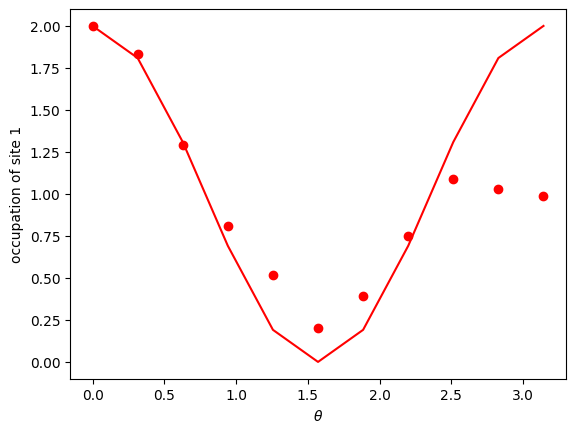

In [28]:
n0s = measurements[:, :, 0]
n1s = measurements[:, :, 1]
n2s = measurements[:, :, 2]
n3s = measurements[:, :, 3]
f, ax = plt.subplots()
ax.plot(phases, 1 + np.cos(2 * phases), "r-")
ax.plot(phases, n0s.mean(axis=1) + n1s.mean(axis=1), "ro")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("occupation of site 1");

We can see a clear effect of the interactions compared to the naive dynamics. For a detailled analysis and comparison o the experimental results, feel free to have a look in this [qiskit](https://qiskit-extensions.github.io/qiskit-cold-atom/tutorials/08_fermions_in_double_well.html) tutorial.
    